## Tutorial: Verificação facial com uma Rede Neurais Siamesa
Nicholas Renotte

https://www.youtube.com/watch?v=LKispFFQ5GU


### Atividade: Aprendizado de Máquina

A abordagem usada no tutorial de reconhecimento facil foi baseada em aprendizado supervisionada com **Redes Neurais Siamesas**, seguida pela reutilização dos recursos dessa rede para o aprendizado **one-shot** , 
•	com isso não há necessidade de qualquer retreinamento quando novas classes venham surgir.
#### Redes Neurais Siamesas
é uma classe de arquiteturas de rede neural que **contém duas ou mais sub-redes idêntico**
* **'idêntico'** - significa que eles têm a mesma configuração com os mesmos parâmetros e pesos
* A atualização de parâmetros é espelhada em ambas as sub-redes. 
#### **one-shot**
* O aprendizado único é um algoritmo de classificação que avalia a semelhança e a diferença entre duas imagens. 
    * Permite efetuar classificação a partir de poucas ou mesmo uma única imagem de treinamento
    
#### Redes Neurais Siamesas

![Rede Neural Siamesa](Redes_Neurais_Siamesas.png)

## 1 - configurações

### 1.1 Intalação de dependencias 

In [1]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

### 1.2 Importe dependencias

In [200]:
# Importar dependências padrão
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [201]:
# Importar dependências do tensorflow - API funcional
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### 1.3 Definir o crescimento da GPU

Para evitar erros de alocação de memoria, foi definido o crescimento do consumo de memória do CPU


In [202]:
# OOM definindo o crescimento do consumo de memória da GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.4 Criar Pastas

Nesta seção é criada as pastas que o algoritmo utiliza:

* **Âncora** - imagem que define quem nós somos.
* **Positivo** - Nessa pasta, está imagens vai confirmar se a imagens da pasta âncora corresponde com as imagens positivas
* **Negativo** - Nessa pasta, temos as imagens negativos que são as imagens que não se assemelham com o arquivo da pasta âncora


In [203]:
# configuração dos Caminho
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [204]:
import os.path

# Vericando se o diretorio ja existe
if os.path.isdir(POS_PATH) and os.path.isdir(POS_PATH) and os.path.isdir(POS_PATH):
      print ('Ja existe uma pasta ja exitem!')
else:
    # aqui criamos a pasta caso nao exista
    os.makedirs(POS_PATH)
    os.makedirs(NEG_PATH)
    os.makedirs(ANC_PATH)
    print ('Pasta criada com sucesso!')

Ja existe uma pasta ja exitem!


## 2. Colete pontos positivos e âncoras

### 2.1 Descompactar rostos rotulados no conjunto de dados selvagem

##### Rostos rotulados da natureza

**Labeled Faces in the Wild** é uma referência pública para verificação facial, também conhecida como correspondência de pares. 
As imagens contidas nesse link http://vis-www.cs.umass.edu/lfw/ foram baixadas e descompactadas para depois serem salvas no repositório data/negative

In [205]:
# Descompacte as faces rotuladas Tar GZ no conjunto de dados selvagens
!tar -xf lfw.tgz

In [14]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Coletar Classes Positivas e Âncoras

As imagens **positivas** e **âncoras** foram coletadas nessa seção atraves da webcam
Coletando as imagens âncoras - Preciona a letras "a"
Coletando as imagens positivas - Preciona a letras "p"

In [206]:
# Import uuid library to generate unique image names
import uuid

In [207]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\4eab8471-71a4-11ed-abea-00d76d057e71.jpg'

In [233]:
# Estabelecendo conexão com webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    # Percorre cada quadro da nossa webcam
    # cap.read:Ler a captura dos quadros
    ret, frame = cap.read()
   
    # Reduz o qaadro 250x250px, para facilitar o processamento
    frame = frame[120:120+250,200:200+250, :]
    
    # Coletando as imagens âncoras - Preciona a letras "a"
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Crie nome unico para o nosso arquivo  
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Escrevendo a imagem em âncor
        cv2.imwrite(imgname, frame)
    
    # Coletando as imagens positivas - Preciona a letras "p"
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Crie nome unico para o nosso arquivo  
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
       # Escrevendo a imagem em positivo
        cv2.imwrite(imgname, frame)
    
    # Mostrar imagem de volta à tela
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Libera a webcam
cap.release()
# Feche o quadro de exibição de imagem
cv2.destroyAllWindows()

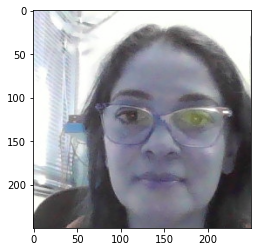

In [234]:
plt.imshow(frame)

### 2.3 NOVO - Aumento de dados

O aumento de dados na análise de dados são técnicas usadas para aumentar a quantidade de dados adicionando cópias ligeiramente modificadas de dados já existentes ou dados sintéticos recém-criados a partir de dados existentes

In [107]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [108]:
import os
import uuid

In [109]:
img_path = os.path.join(ANC_PATH, 'b02660de-6ed9-11ed-a069-00d76d057e71.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

## 3. Carregar e pré-processar imagens

### 3.1 Obter diretorio das imagens

In [112]:
    """
    :variavel anchor: tensorflow.python.data.ops.dataset_ops.TakeDataset
    :variavel positive: tensorflow.python.data.ops.dataset_ops.TakeDataset
    :variavel negative: tensorflow.python.data.ops.dataset_ops.TakeDataset
    
    o metodo tf.data.Dataset.list_files cria um conjunto ou um pipeline para as imagens diferentes dentro de um determinado diretório
    """
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [113]:
dir_test = anchor.as_numpy_iterator()

In [114]:
# Pega o caminho da imagens dentro do diretório
print(dir_test.next())

b'data\\anchor\\aa48884e-6ed8-11ed-bd79-00d76d057e71.jpg'


### 3.2 Pré-processamento - Dimensionar e redimensionar

A função preprocess converte os valosres da imagens de 0 a 255 para 0 e 1
* Essa função tem como retorno as imagens com o valor converti entre 0 e 1

In [115]:
# Converter todos os valores da imagens de 0 a 255 para 0 e 1
def preprocess(file_path):
    
    """
    Returns retornar as imagens em escala entre 0 e 1.
    :variavel img: tensorflow.python.framework.ops.EagerTensor
    :param file_path: String
    
    """
    
    # Lendo a imagem do caminho do arquivo
    byte_img = tf.io.read_file(file_path)
    # carrega na imagem
    img = tf.io.decode_jpeg(byte_img)
    
    # Etapas de pré-processamento - redimensionando a imagem para 100x100x3
    img = tf.image.resize(img, (100,100))
    # Escala da imagem para ficar entre 0 e 1
    img = img / 255.0

    # Return image com valores convertidos entre 0 e 1
    return img

In [116]:
img = preprocess('data\\anchor\\b02660de-6ed9-11ed-a069-00d76d057e71.jpg')

In [117]:
type(img)

tensorflow.python.framework.ops.EagerTensor

In [118]:
img.numpy().max() 

1.0

### 3.3 Criar conjunto de dados rotulados

##### Dados de entrada para rede neural siamesa com perda trigêmea

O aprendizado foi feito com a perda de trigêmea.
* Para a perda por trigêmeos temos:
    * Um vetor de linha base **(imagens ancôra)** é comparado com:
        * com um vetor positivo **(imagem verdadeira)**
        * e com um vetor negativo **(imagem falsa)**
       
O vetor negativo forçará o aprendizado na rede, enquanto o vetor positivo atuará como um regularizador. 

##### Dados de entrada para rede neural siamesa
* (anchor, positive) => 1,1,1,1,1
* (anchor, negative) => 0,0,0,0,0


In [119]:
# Dados de entrada para rede neural siamesa
# imagens positivas mais nossa ancora = 1
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
# imagens negativas mais nossa ancora = 0
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
# junta os positivos e negativos da amostra
data = positives.concatenate(negatives)

In [120]:
samples = data.as_numpy_iterator()

In [121]:
exampple = samples.next()

In [122]:
exampple

(b'data\\anchor\\58aed36f-6ed9-11ed-89cd-00d76d057e71.jpg',
 b'data\\positive\\18209d22-712d-11ed-af9b-00d76d057e71.jpg',
 1.0)

### 3.4 Construir partição de treinamento e teste

In [123]:
# Pré processamento da função gemeas
def preprocess_twin(input_img, validation_img, label):
    # Executa o pré-processamento em reprocess(input_img) com imagens de entrada
    #  e no pré-processamento de imagem validação
    return(preprocess(input_img), preprocess(validation_img), label)

In [124]:
res = preprocess_twin(*exampple)

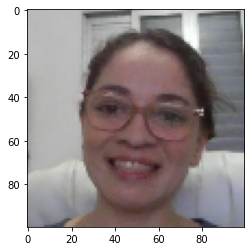

In [125]:
plt.imshow(res[0])

In [126]:
# Etiqueta 1, temos uma foto positiva - Etiquetada corretamente
res[2]

1.0

In [127]:
# Cria pipeline do carregamento dos dados
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [128]:
# Separando dados para treino
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [129]:
# Separando dados para o teste
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## 4. Engenharia de modelos

### 4.1 Criar Camada Incorporada

#### Arquitetura convolucional selecionada para tarefa de verificação

![Melhor arquitetura convolucional selecionada para tarefa de verificação](seamese.png)

##### O gêmeo siamês não é representado, mas se une imediatamente após a camada totalmente conectada de 4096 unidades, onde a distância entre os vetores L1 é calculada

* **Input**: entrada do algoritmo (imagens);
* **Conv2D**: utilizada para criar as camadas da rede neural convolucional e usa o **relu** como ativação;
* **Dense** : camada conectada;
* **MaxPooling2D** : o pooling máximo reduz a dimensionalidade das imagens reduzindo o número de pixels na saída da camada convolucional anterior;
* **Flatten**: "achata" as informações da camada anterior em uma única dimensão, permitindo assim, enviar os dados da rede convolucionoal para a camada densa.

In [130]:
inp = Input(shape=(100,100,3), name='input_image')
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [131]:
# Aqui temos 64 canais (filtros) com 91 pixels por 91 pixels - Convolution + Rule e usando o max-poolling 
c1 = Conv2D(64, (10,10), activation='relu')(inp)
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d_8')>

In [132]:
# CAmada de agrupamento máximo reunindo 2D 
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [133]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c2

<KerasTensor: shape=(None, 40, 40, 128) dtype=float32 (created by layer 'conv2d_9')>

In [134]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c3

<KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'conv2d_10')>

In [135]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1) # Vetor de recurosos 4096 -  distância siamesa
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_11')>

In [136]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense_4')>

In [137]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [138]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 128)         0 

In [139]:
def make_embedding(): 
    # Camada de entrada com 100 pixel por 100 pixels e tres canais
    inp = Input(shape=(100,100,3), name='input_image')
    
    # Primeiro bloco
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Segundo bloco
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Terceiro bloco 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Bloco de incorporação final
    # Temos 256 filtros
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    
    # Camada densa (saída achatada com uma dimensão)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    """
    Returns retornar a camada de entrada (inputs), a saida é a camada achatada com 1 dimensão e uma string

    """
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [140]:
embedding = make_embedding()

In [141]:
# O modelo criado
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 9, 128)         0 

### 4.2 Criar Camada de Distância

In [142]:
# Classe à Distância Siamês L1
class L1Dist(Layer):
    
    # Método init - herança
    def __init__(self, **kwargs):
        super().__init__()

    # cálculo de similaridade
    def call(self, input_embedding, validation_embedding):        
        """
        Returns - retornar o valor absoluto do calculo da similaridade 
        (input_embedding - validation_embedding), ou seja, vai retornar a distância.

        """
        return tf.math.abs(input_embedding - validation_embedding)

In [143]:
l1 = L1Dist()

In [144]:
l1

### 4.3 Fazer Modelo Siamês

In [145]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [146]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [147]:
siamese_layer = L1Dist()

In [148]:
distances = siamese_layer(inp_embedding, val_embedding)

In [149]:
classifier = Dense(1, activation='sigmoid')(distances)

In [150]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [151]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [152]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_5 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [153]:
def make_siamese_model(): 
    
    # Ancorar entrada de imagem na rede
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Imagem de validação na rede 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combinar componentes de distância siameses
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    # distância entre as iamgens de entrada e as imagens de validação - 
    # verifica a semelhança entre as imagens para ver se é a mesma pessoa
    distances = siamese_layer(embedding(input_image), embedding(validation_image)) 
    
    # Camada de classificação
    classifier = Dense(1, activation='sigmoid')(distances)
    
    """
    Returns - retornar o modelo com inputs que é um vetor com input_image e a validation_image, a outputs que
    é a classificação se é a mesma pessoa ou não e, por fim, o nome da rede siamesa
    
    """
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [154]:
siamese_model = make_siamese_model()

In [155]:
# Modelo embedding
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

## 5. Treinamento

### 5.1 Perda de Configuração e Otimizador

In [156]:
# Calcula a perda de entropia cruzada entre rótulos verdadeiros e rótulos previstos.
binary_cross_loss = tf.losses.BinaryCrossentropy()

A otimização de Adam é um método de descida de gradiente estocástico baseado na estimativa adaptativa de momentos de primeira e segunda ordem.

In [157]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### 5.2 Estabelecer Pontos de Verificação

In [158]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### 5.3 Construir função de etapa de treinamento

In [159]:
test_batch = train_data.as_numpy_iterator()

In [160]:
batch_1 = test_batch.next()

In [161]:
X = batch_1[:2]

In [162]:
y = batch_1[2]

In [163]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [164]:
y

array([0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

In [165]:
tf.losses.BinaryCrossentropy??

In [166]:
@tf.function
def train_step(batch):
    
    # Registre todas as operações
    with tf.GradientTape() as tape:     
        # Obtenha âncora e imagem positiva/negativa
        X = batch[:2]
        # obtendo etiqueta
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calcular perda
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calcaula o gradiente
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calcular pesos atualizados e aplicar ao modelo siamês
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return o calculo dA PERDA
    return loss

### 5.4 Construir Loop de Treinamento

In [167]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [168]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### 5.5 Treinar o modelo

In [169]:
EPOCHS = 50

In [170]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
13/13 [==============================] - 233s 18s/step
0.3188168 0.65178573 1.0

 Epoch 2/50
13/13 [==============================] - 230s 18s/step
0.114726625 0.95238096 1.0

 Epoch 3/50
13/13 [==============================] - 223s 17s/step
0.0053823623 0.969697 1.0

 Epoch 4/50
13/13 [==============================] - 212s 16s/step
0.13882488 0.9809524 0.99038464

 Epoch 5/50
13/13 [==============================] - 221s 17s/step
0.027855847 1.0 1.0

 Epoch 6/50
13/13 [==============================] - 215s 17s/step
0.0001675985 1.0 1.0

 Epoch 7/50
13/13 [==============================] - 239s 19s/step
0.1004316 0.9907407 1.0

 Epoch 8/50
13/13 [==============================] - 245s 19s/step
0.0014648061 1.0 1.0

 Epoch 9/50
13/13 [==============================] - 241s 19s/step
0.00028033435 1.0 1.0

 Epoch 10/50
13

# 6. Avaliar modelo

Aqui esta sendo realizado a avaliação do modelo, foram utilizados as metricas **Precision** e **Recall**
* **Precision** -  Precisão é a proporção de classes positivas previstas corretamente para todos os itens previstos como positivos
* **Recall** - é a proporção de classes positivas previstas corretamente para todos os itens que são realmente positivos

Nesse tópico, foi realizada:
* importação das métricas
* previsões
* Calculo das métricas
* apresenta o resultado da visualização



## 6.1 Import Métricas

In [171]:
# Importr métricas para calcular Precision e Recall
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Fazer previsões

In [172]:
# Obtenha os dados de teste
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [173]:
y_hat = siamese_model.predict([test_input, test_val])

In [174]:
# Pós-processamento dos resultados
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]

In [175]:
y_true

array([0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.],
      dtype=float32)

## 6.3 Calcular Métricas

In [176]:
# Criando um objeto de métrica 
m = Recall()

# Calculando o valor do recall
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [177]:
# Criando um objeto de métrica
m = Precision()

# Calculando o valor do Precision
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [178]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


## 6.4 Resultados da Visualização

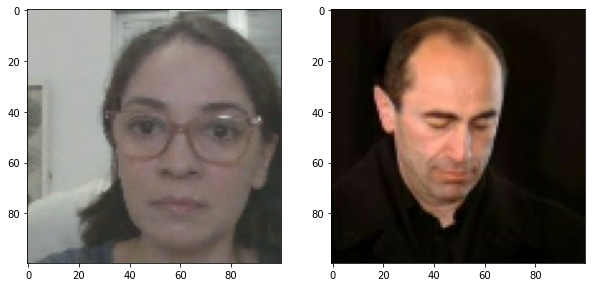

In [179]:
# Definindo o tamanho do gráfico
plt.figure(figsize=(10,8))

# Definindo a primeira imagem
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Definindo a segunda imagem
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Salvar o Modelo

In [181]:
# Salvabdo os pesos
siamese_model.save('siamesemodelv2.h5')

In [182]:
L1Dist

__main__.L1Dist

In [183]:
# Recarregando o modelo
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [184]:
# previsões com modelo recarregado
siamese_model.predict([test_input, test_val])

array([[8.5608243e-10],
       [8.4871221e-11],
       [6.6700569e-12],
       [2.0537044e-10],
       [3.7757106e-11],
       [3.3738130e-11],
       [9.9977964e-01],
       [9.9999940e-01],
       [1.0000000e+00]], dtype=float32)

In [185]:
# resumo do modelo
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_7 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Teste em tempo real


Nesse tópico esta sendo realizado a verificação em tempo real, onde é usado 
* a imagem da webcan como imagens de entrada **input_image** 
    * ao apertar v a imagen será salva na pasta **input_image**
e sem sequida chama a função **verify** para realizar a verifcação baseado nas imagens que estão na pasta application_data\verification_images

## 8.1 Função de verificação

In [215]:
os.listdir(os.path.join('application_data', 'verification_images'))

['00b2e8b6-6e07-11ed-bcbd-d09466ce65be - Copia (2).jpg',
 '00b2e8b6-6e07-11ed-bcbd-d09466ce65be - Copia - Copia.jpg',
 '01acae22-6e07-11ed-970e-d09466ce65be - Copia - Copia.jpg',
 '39ad0b65-6e07-11ed-afc7-d09466ce65be - Copia - Copia.jpg',
 '3c27fafe-6e07-11ed-b810-d09466ce65be.jpg',
 '473791d6-6e07-11ed-98ba-d09466ce65be.jpg',
 '47dc19f2-6e07-11ed-93d7-d09466ce65be - Copia.jpg',
 '47fd5f2b-6e07-11ed-b87c-d09466ce65be - Copia.jpg',
 '4e8c9034-6e07-11ed-b3a4-d09466ce65be - Copia.jpg',
 '526082a9-6e07-11ed-86bb-d09466ce65be.jpg',
 '56f0f797-6e07-11ed-85e9-d09466ce65be - Copia.jpg',
 '56f0f797-6e07-11ed-85e9-d09466ce65be.jpg',
 '5c0ee9a6-6e07-11ed-90bf-d09466ce65be.jpg',
 '66061e36-6e07-11ed-84fc-d09466ce65be.jpg',
 'b15d9f7e-6e06-11ed-a117-d09466ce65be.jpg',
 'b38965f3-6e06-11ed-a7c0-d09466ce65be.jpg',
 'b44466ba-6e06-11ed-bde0-d09466ce65be.jpg',
 'b5d480c0-6e06-11ed-8c3f-d09466ce65be.jpg',
 'd4714f64-6e07-11ed-b703-d09466ce65be.jpg',
 'd4b0aa4a-6e07-11ed-85c0-d09466ce65be.jpg',
 'd4d273

In [216]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [217]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\00b2e8b6-6e07-11ed-bcbd-d09466ce65be - Copia (2).jpg
application_data\verification_images\00b2e8b6-6e07-11ed-bcbd-d09466ce65be - Copia - Copia.jpg
application_data\verification_images\01acae22-6e07-11ed-970e-d09466ce65be - Copia - Copia.jpg
application_data\verification_images\39ad0b65-6e07-11ed-afc7-d09466ce65be - Copia - Copia.jpg
application_data\verification_images\3c27fafe-6e07-11ed-b810-d09466ce65be.jpg
application_data\verification_images\473791d6-6e07-11ed-98ba-d09466ce65be.jpg
application_data\verification_images\47dc19f2-6e07-11ed-93d7-d09466ce65be - Copia.jpg
application_data\verification_images\47fd5f2b-6e07-11ed-b87c-d09466ce65be - Copia.jpg
application_data\verification_images\4e8c9034-6e07-11ed-b3a4-d09466ce65be - Copia.jpg
application_data\verification_images\526082a9-6e07-11ed-86bb-d09466ce65be.jpg
application_data\verification_images\56f0f797-6e07-11ed-85e9-d09466ce65be - Copia.jpg
application_data\verification_images\56f0f797-6e07

In [218]:
def verify(model, detection_threshold, verification_threshold):
    # Criar matriz de resultados
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Fazer previsões
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: métrica acima da qual uma previsão é considerada positiva
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Proporção de previsões positivas/total de amostras positivas
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
   

    """
    R Returns - Rertorna o results que é os resultados da verificação da imagens de entrada com as imagens 
    contidas na pasta em application_data\verification_images e a verified
    
    verified: True se a foto corresponder e False caso foto não corresponda
    """
   
    
    return results, verified

## 8.2 Verificação em tempo real do OpenCV

In [235]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Salve a imagem de entrada na pasta application_data/input_image 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Executar verificação
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
False


In [226]:
np.sum(np.squeeze(results) > 0.9)

14

In [227]:
results

[array([[0.9985056]], dtype=float32),
 array([[0.9985056]], dtype=float32),
 array([[0.00642663]], dtype=float32),
 array([[7.903098e-06]], dtype=float32),
 array([[1.3578905e-05]], dtype=float32),
 array([[0.00031605]], dtype=float32),
 array([[0.002718]], dtype=float32),
 array([[0.00303003]], dtype=float32),
 array([[0.18011454]], dtype=float32),
 array([[0.02104488]], dtype=float32),
 array([[5.2341957e-06]], dtype=float32),
 array([[5.2341957e-06]], dtype=float32),
 array([[5.5950175e-05]], dtype=float32),
 array([[3.9975224e-05]], dtype=float32),
 array([[0.32143456]], dtype=float32),
 array([[0.02331591]], dtype=float32),
 array([[0.9616779]], dtype=float32),
 array([[0.24936622]], dtype=float32),
 array([[0.9997822]], dtype=float32),
 array([[0.00056672]], dtype=float32),
 array([[0.01006079]], dtype=float32),
 array([[0.00020933]], dtype=float32),
 array([[0.99952555]], dtype=float32),
 array([[9.072754e-05]], dtype=float32),
 array([[0.18682826]], dtype=float32),
 array([[0.9